# 🧬 Part 2 of the [MPEG-G Microbiome Classification Challenge](https://zindi.africa/competitions/mpeg-g-microbiome-classification-challenge) starter code.

In Part 1 we read in the MPEG-G files using Genie, converted them to fastq. In this notebook we will explore the data about the study participants (Subjects) and the fastq files before we start modeling.

In this notebook we will only focus on a centralised model appro

## 🧠 The Plan for EDA and Modeling

1. 📊 Explore the subject information
2. 👀 Explore the fastq files
3. 🔨 Create features for modeling
4. ⏳ Run *** model
5. 📤 Format submission file to be submitted to Zindi
6. 💡 Next steps and ideasach.

In [ ]:
!pip install Bio

In [ ]:
# Import packages
import os
import zipfile
import subprocess
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil


from Bio import SeqIO
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Errors ignore
import warnings
warnings.filterwarnings('ignore')

In [ ]:
path = ""              # Update to your path

In [ ]:
# Read in csv files

train_df = pd.read_csv(path + "/Train.csv")
test_df = pd.read_csv(path + "/Test.csv")
train_subjects_df = pd.read_csv(path + "/Train_Subjects.csv")
ss = pd.read_csv(path + "/SampleSubmission.csv")

### 📊 Step 1: Explore the train, test & subject information

In [ ]:
train_df.head()

,filename,SampleType,SubjectID,SampleID
0,ID_LETPJN.mgb,Stool,Subject_BCUNIB,Sample_AFTIWE
1,ID_NTDGIW.mgb,Stool,Subject_UDAXIH,Sample_JQJVNK
2,ID_ZISBMF.mgb,Nasal,Subject_VRKADI,Sample_YJWGWW
3,ID_MDCVXU.mgb,Nasal,Subject_HIFZWD,Sample_VKEHZP
4,ID_SWAMNY.mgb,Stool,Subject_VGLNCV,Sample_NTDTEQ


In [ ]:
print(f"Number of unique subjects in train_df: {train_df['SubjectID'].nunique()}")
print(f"Number of unique SampleType in train_df: {train_df['SampleType'].nunique()}")
print(f"Number of unique Files in train_df: {train_df['filename'].nunique()}")
print(f"Unique values in SampleType: {train_df['SampleType'].unique()}")

train_df.head()

Number of unique subjects in train_df: 66
Number of unique SampleType in train_df: 4
Number of unique Files in train_df: 2901
Unique values in SampleType: ['Stool' 'Nasal' 'Mouth' 'Skin']


,filename,SampleType,SubjectID,SampleID
0,ID_LETPJN.mgb,Stool,Subject_BCUNIB,Sample_AFTIWE
1,ID_NTDGIW.mgb,Stool,Subject_UDAXIH,Sample_JQJVNK
2,ID_ZISBMF.mgb,Nasal,Subject_VRKADI,Sample_YJWGWW
3,ID_MDCVXU.mgb,Nasal,Subject_HIFZWD,Sample_VKEHZP
4,ID_SWAMNY.mgb,Stool,Subject_VGLNCV,Sample_NTDTEQ


Average number of files per SubjectID in train_df: 43.95


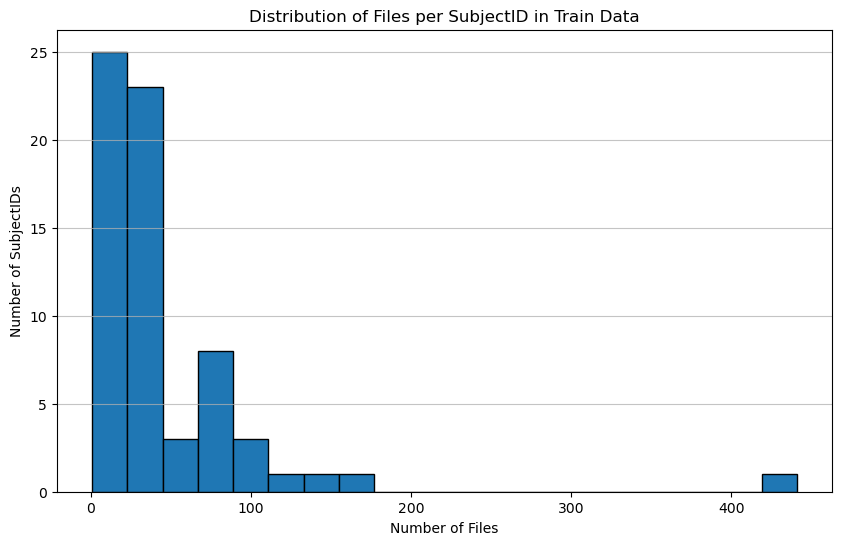

In [ ]:
# Visualise the average number of files per SubjectID

files_per_subject = train_df.groupby('SubjectID')['filename'].count().reset_index()
files_per_subject = files_per_subject.rename(columns={'filename': 'FileCount'})
average_files_per_subject = files_per_subject['FileCount'].mean()
print(f"Average number of files per SubjectID in train_df: {average_files_per_subject:.2f}")
plt.figure(figsize=(10, 6))
plt.hist(files_per_subject['FileCount'], bins=20, edgecolor='black')
plt.title('Distribution of Files per SubjectID in Train Data')
plt.xlabel('Number of Files')
plt.ylabel('Number of SubjectIDs')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
print(f"Number of unique Files in test_df: {test_df['filename'].nunique()}")
test_df.head()

Number of unique Files in test_df: 1068


,filename
0,ID_YBNOYC.mgb
1,ID_HPVLUO.mgb
2,ID_DQGGYD.mgb
3,ID_XZBUJB.mgb
4,ID_KRPYRQ.mgb


In [ ]:
train_subjects_df.head()

,SubjectID,FPG_Mean,FPG_class,IRIS,SSPG,FPG,SSPG.Date,Class,Gender,Ethnicity,Adj.age,BMI,OGTT,OGTT_Class,Longitudinal.HbA1C.Group,A1C_Class,Family
0,Subject_UDAXIH,1.274432,Diabetes,IS,91.5,131.75,8/7/14,Diabetic,M,C,59.48,21.47,2.245,Diabetes,6. Variable Diabetic-PreDM (n = 8),6.VDP,NaN
1,Subject_NHOSIZ,0.915833,Normal,Unknown,NaN,NaN,NaN,Prediabetic,M,C,61.17,27.06,1.005,Normal,3. PreDM-to-Normal (n = 10),3.PN,NaN
2,Subject_AYZFWN,0.952000,Normal,Unknown,NaN,NaN,NaN,Prediabetic,F,A,56.22,30.61,NaN,NaN,1. Normal (n = 51),1.Normal,NaN
3,Subject_KIEGYK,1.160000,Prediabetes,Unknown,NaN,NaN,NaN,Prediabetic,M,C,49.18,23.22,NaN,NaN,1. Normal (n = 51),1.Normal,NaN
4,Subject_CBVHYJ,0.880000,Normal,Unknown,NaN,NaN,NaN,Control,F,C,46.04,25.26,0.930,Normal,1. Normal (n = 51),1.Normal,NaN


In [ ]:
train_subjects_df.describe()

,FPG_Mean,SSPG,FPG,Adj.age,BMI,OGTT
count,66.000000,44.000000,44.000000,66.000000,66.000000,56.000000
mean,0.940581,149.815000,99.937500,54.976212,27.895000,1.371667
std,0.117552,68.402027,11.397818,10.315599,4.334436,0.455184
min,0.756000,40.000000,78.000000,29.180000,19.100000,0.640000
25%,0.870000,90.375000,94.750000,49.772500,25.040000,1.089167
50%,0.902557,156.935000,97.500000,55.300000,27.195000,1.250000
75%,1.017500,220.000000,101.937500,61.747500,30.092500,1.533125
max,1.274432,274.000000,138.000000,75.230000,40.830000,3.087500


### 👀 Step2: Explore the fastq files

In [ ]:
fastq_dir = "TrainFiles"
all_stats = []

for fname in os.listdir(fastq_dir):
    if not fname.endswith(".fastq"):
        continue

    path = os.path.join(fastq_dir, fname)
    read_lengths = []
    gc_counts = []
    nt_counts = Counter()

    for record in SeqIO.parse(path, "fastq"):
        seq = str(record.seq)
        read_lengths.append(len(seq))
        gc_counts.append(seq.count("G") + seq.count("C"))
        nt_counts.update(seq)

    if read_lengths:
        stats = {
            "file": fname,
            "num_reads": len(read_lengths),
            "avg_read_length": sum(read_lengths) / len(read_lengths),
            "avg_gc_content": sum(gc_counts) / sum(read_lengths),
            "A": nt_counts["A"],
            "T": nt_counts["T"],
            "G": nt_counts["G"],
            "C": nt_counts["C"]
        }
        all_stats.append(stats)

# Convert to DataFrame
df = pd.DataFrame(all_stats)

In [ ]:
# Basic feature table to assess the features created from the FASTQ files
df.head()

In [ ]:
# Plot: GC content distribution
plt.figure()
plt.hist(df["avg_gc_content"], bins=20, color='gray')
plt.title("GC Content Distribution")
plt.xlabel("GC Content")
plt.ylabel("Number of Files")
plt.show()

In [ ]:
# Define your folder and labels
fastq_dir = "TrainFiles"
labels = ['Nasal', 'Stool', 'Mouth', 'Skin']

# List all .fastq files in the folder
file_list = [f for f in os.listdir(fastq_dir) if f.endswith(".fastq")]

# Assign a random label to each file
data = {
    "filename": file_list,
    "label": [random.choice(labels) for _ in file_list]
}

# Create the DataFrame
df_labels = pd.DataFrame(data)

# Optional: sort for cleaner viewing
df_labels = df_labels.sort_values("filename").reset_index(drop=True)

# Show the result
df_labels.head()

In [ ]:
# Visualise count of label

import matplotlib.pyplot as plt
# Count the occurrences of each label
label_counts = df_labels['label'].value_counts()

# Plotting the label counts
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 🔨 Step 3: Create features for modeling (remember to create your new and better features)
For example, extract number of specific length sequences (di-nucleotides, tri-nucleotides, k-nucleotides)  

Or, use a language model to work directly with  the ACGT data within files.
Alternative: try to use compressed data from MPEG-G - this would be a big stretch.

In [ ]:
def extract_features_from_fastq(path):
    read_lengths = []
    gc_counts = []
    nt_counter = Counter()

    for record in SeqIO.parse(path, "fastq"):
        seq = str(record.seq)
        read_lengths.append(len(seq))
        gc_counts.append(seq.count("G") + seq.count("C"))
        nt_counter.update(seq)

    if not read_lengths:
        return None  # skip empty files

    total_len = sum(read_lengths)
    return {
        "num_reads": len(read_lengths),
        "avg_read_len": total_len / len(read_lengths),
        "gc_content": sum(gc_counts) / total_len,
        "A": nt_counter["A"] / total_len,
        "T": nt_counter["T"] / total_len,
        "G": nt_counter["G"] / total_len,
        "C": nt_counter["C"] / total_len,
    }

In [ ]:
train_dir = "TrainFiles"
train_features = []

for _, row in df_labels.iterrows():
    fpath = os.path.join(train_dir, row["filename"])
    feats = extract_features_from_fastq(fpath)
    if feats:
        feats["filename"] = row["filename"]
        feats["label"] = row["label"]
        train_features.append(feats)

df_train = pd.DataFrame(train_features)

In [ ]:
# Encode string labels to integers
le = LabelEncoder()
df_train["label_enc"] = le.fit_transform(df_train["label"])

In [ ]:
# Define features & target
X = df_train[["num_reads", "avg_read_len", "gc_content", "A", "T", "G", "C"]]
y = df_train["label_enc"]

In [ ]:
X.to_csv("X.csv", index = False)
y.to_csv("y.csv", index = False)

### ⏳ Step 4: Run RandomForestClassifier model


In [ ]:
# Train/test split for evaluation
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=42)

In [ ]:
# Train classifier
clf = RandomForestClassifier(n_estimators=10, random_state=42)
clf.fit(X_train, y_train)

In [ ]:
# Evaluate
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred, target_names=le.classes_))

In [ ]:
test_dir = "TestFiles"
test_files = [f for f in os.listdir(test_dir) if f.endswith(".fastq")]

test_features = []
for fname in test_files:
    path = os.path.join(test_dir, fname)
    feats = extract_features_from_fastq(path)
    if feats:
        feats["filename"] = fname
        test_features.append(feats)

df_test = pd.DataFrame(test_features)

In [ ]:
# Predict
X_test = df_test[["num_reads", "avg_read_len", "gc_content", "A", "T", "G", "C"]]

In [ ]:
# Get class probabilities
probs = clf.predict_proba(X_test)

# Create output DataFrame
probs_df = pd.DataFrame(probs, columns=le.inverse_transform(clf.classes_))  # class labels as column names
probs_df.insert(0, "filename", df_test["filename"])
probs_df.head()

### 📤 Step 5: Format submission file to be submitted to Zindi

In [ ]:
# Sort columns to match required order
required_order = ["filename", "Mouth", "Nasal", "Skin", "Stool"]
for col in required_order[1:]:
    if col not in probs_df.columns:
        probs_df[col] = 0.0  # in case some class not seen in train

probs_df = probs_df[required_order]
probs_df["filename"] = probs_df["filename"].str.replace(".fastq", "", regex=False)

# View
probs_df.head()

In [ ]:
# Save to CSV
probs_df.to_csv("test_predictions_probs.csv", index=False)